# Unified View Modelling for Akwa Ibom: Augmented Model
**Author:** Marang Mutloatse

**Description:** This script performs cohort modelling on the UV for Akwa Ibom

**Version:** 0.0.1

**Status:** Completed

## Import Libraries

In [1]:
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
import pandas as pd
import yaml
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
sys.path.insert(0,package_path + '/src/')
from hiv_support_package import visit_features,helper_functions,evaluation_metrics,model_validation
from sklearn.impute import SimpleImputer
from datetime import timedelta, date
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
import pandas as pd
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit,GridSearchCV
from numpy import mean
from numpy import std
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import mlflow
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions


In [2]:
def one_hot_encode_col(df,dummies_col:str,prefix_entry:str):
    if df is not None:
        try:
            dummies = pd.get_dummies(df[dummies_col], prefix=prefix_entry,drop_first=False)
            df = df.join(dummies)
            return df
        except Exception as e:
            print(f"Exception on one hot encoding with error: {e}")

## Loading Data

In [3]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [4]:
input_root = config['rise_files']['raw_data_path']
uv_file = config['output_files']['unified_view_file']
uv_input = input_root + uv_file

akwa_ibom = config['cohort_analysis']['akwa_ibom_cohort']
akwa_ibom = int(akwa_ibom)
print(uv_input)
print(akwa_ibom)

/data/rise_data/unified_view.csv
1


In [5]:
%%time
df = pd.read_csv(uv_input,low_memory=False)

CPU times: user 41.5 s, sys: 2.72 s, total: 44.3 s
Wall time: 44.3 s


## Initial Checks

In [6]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 341 columns and 606136 rows.


In [7]:
pd.set_option('max_rows',None)
helper_functions.check_null_values(df)

There are 143 columns that have missing values


Missing Values  \
P_DATE_REGISTRATION                                         606136   
O_EF_DAYS_SINCE_FIRST_OTZ                                   598097   
O_DATE                                                      598097   
O_PATIENT_ID                                                598097   
O_EF_FIRST_DATE_OTZ                                         573290   
E_DATE                                                      573076   
E_PATIENT_ID                                                573076   
E_EF_OTZ_STARTED                                            527191   
E_EF_FIRST_DATE_EAC                                         507749   
L_T_VL_UNDETECT_40                                          351786   
L_EF_DAY_OF_WEEK_DATE_REPORTED                              351786   
L_EF_IS_WEEKEND_DATE_REPORTED                               351786   
L_EF_WEEK_OF_MONTH_DATE_REPORTED                            351786   
L_EF_QUARTER_DATE_REPORTED                                  351786   
L_EF_IS_START_OF_QUARTER_DATE_REPORTED                      351786   
L_EF_IS_END_OF_QUARTER_DATE_REPORTED                        351786   
L_EF_SEASON_DATE_REPORTED                                   351786   
L_T_VL_UNSUPP_1000                                          351786   
L_T_RISE_VL_CATEGORIZATION                                  351786   
L_T_VL_SUPP_1000                                            351786   
L_T_VL_SUPP_400                                             351786   
L_EF_IS_END_OF_MONTH_DATE_REPORTED                          351786   
L_T_VL_UNSUPP_400                                           351786   
L_EF_VL_COUNT                                               351786   
L_EF_LAST_VL_VALUE                                          351786   
L_EF_DAY_OF_MONTH_DATE_REPORTED                             351786   
L_RESULTAB                                                  351786   
L_EF_IS_START_OF_MONTH_DATE_REPORTED                        351786   
L_DATE_REPORTED                                             351786   
L_EF_VL_CUMMIN                                              351786   
L_EF_MONTH_DATE_REPORTED                                    351786   
L_PATIENT_ID                                                351786   
L_FACILITY_ID                                               351786   
L_LABORATORY_ID                                             351786   
L_DATE_COLLECTED                                            351786   
L_EF_VL_CUMMAX                                              351786   
L_COMMENT                                                   351786   
L_EF_YEAR_DATE_REPORTED                                     351786   
L_EF_VL_VAL                                                 351786   
C_BP                                                        292734   
C_EF_NEXT_ACTUAL_VISIT_DATE                                 190373   
C_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_V...          190373   
C_T_DAYS_UNTIL_ACTUAL_VISIT_DATE                            190373   
P_DATE_CONFIRMED_HIV                                        139063   
V_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_V...           78945   
V_EF_NEXT_ACTUAL_VISIT_DATE                                  78945   
V_EF_DAYS_BETWEEN_MEDS_CONSUMED_AND_ACTUAL_VISI...           78945   
V_T_DAYS_UNTIL_ACTUAL_VISIT_DATE                             78945   
C_ADHERENCE_LEVEL                                            35833   
C_EF_DAYS_SINCE_LAST_VISIT                                   30996   
C_T_IS_LAST_VISIT                                            30996   
C_T_NEXT_VISIT_FURTHER_THAN_60_DAYS                          30996   
C_T_MISSED_NEXT_VISIT_90                                     30996   
C_T_MISSED_NEXT_VISIT_60                                     30996   
C_T_MISSED_NEXT_VISIT_28                                     30996   
C_T_MISSED_NEXT_VISIT_7                                      30996   
C_EF_MONTHS_SINCE_FIRST_VISIT                                3

In [8]:
# Dropping unnecssary columns
drop_some_cols = [
    "P_DATE_NEXT_CLINIC",
    "P_DATE_LAST_CLINIC",
    "V_PHARMACY_ID",
    "L_T_VL_SUPP_400",
    "L_T_VL_UNSUPP_400",
    "P_REGIMENTYPE",
    "L_LABORATORY_ID",
    "L_FACILITY_ID",
    "L_DATE_REPORTED",
    "L_DATE_COLLECTED",
    "P_PATIENT_ID",
    "P_DATE_NEXT_REFILL",
    "L_PATIENT_ID",
    "L_T_VL_UNSUPP_1000",
    "P_DATE_LAST_REFILL",
    "P_LAST_VIRAL_LOAD",
    "P_LAST_CD4",
    "P_LAST_CD4P",
    "P_REGIMEN",
    "P_DATE_CONFIRMED_HIV",
    "P_DATE_STARTED",
    "P_DATE_REGISTRATION",
    "P_DATE_BIRTH",
    "L_T_VL_UNDETECT_40",
    "E_EF_OTZ_STARTED",
    "E_PATIENT_ID",
    "E_DATE",
    "E_EF_FIRST_DATE_EAC",
    "E_EF_OTZ_STARTED",
    "C_CD4",
    "C_CD4P",
    "C_TB_STATUS",
    "C_BP",
    "C_EF_FIRST_DATE_VISIT",
    "C_EF_ID_SEQUENCE",
    "C_EF_DIFFERENT_LAST_FACILIITY",
    "C_EF_LAST_FACILITY_ID",   
]
df.drop(columns=drop_some_cols,inplace=True)

In [9]:
df = df.sort_values(by=['V_PATIENT_ID','V_DATE_VISIT'])

### Inclusion Criteria

In [10]:
df = df.loc[df['V_EF_STATE_AKWA_IBOM'] == 1]
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 228314 rows.


In [11]:
# Filter date
df = df.loc[(df['EF_START_DATE_TREATMENT'] >= '2017-01-01 00:00:00') & (df['V_DATE_VISIT'] <= '2021-05-31 00:00:00')]

In [12]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 152123 rows.


In [13]:
# Filter out for records that only have one occurrence
df = df[df['V_PATIENT_ID'].map(df['V_PATIENT_ID'].value_counts() > 1)]

In [14]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 147049 rows.


In [15]:
# Status list to Exclude
current_status_list = [
"Known Death",
"Hiv+ Non Art",
"Hiv Exposed Status Unknown",
"Hiv Exposed Infant Status Unknown",
"Pre-Art Transfer Out",
"Hiv Exposed Infant Status Unknown","Died"]
df = df[~df['P_CURRENT_STATUS'].isin(current_status_list)]

## UV encoding and binning

In [16]:
# Rounding Age and Time in treatment to closest digits
df['EF_AGE_AT_START'] = df['EF_AGE_AT_START'].astype(int)
df['EF_AGE_AT_VISIT'] = df['EF_AGE_AT_VISIT'].astype(int)
df['EF_TIME_IN_TREATMENT_MONTHS'] = round(df['EF_TIME_IN_TREATMENT_MONTHS'],2)

In [17]:
# Some cleaning and FE of date of visits
df['U_EF_FIRST_DATE_VISIT'] = df.groupby('V_PATIENT_ID')['V_DATE_VISIT'].transform('min')
df['U_EF_FIRST_DATE_VISIT'] = pd.to_datetime(df['U_EF_FIRST_DATE_VISIT'])
df['V_DATE_VISIT'] = pd.to_datetime(df['V_DATE_VISIT'])
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = ((df['V_DATE_VISIT'] - df['U_EF_FIRST_DATE_VISIT'])/np.timedelta64(1, 'M'))
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'].fillna(0).astype(int)

In [18]:
# Binning of Some of the  
df['U_EF_NUM_MISSED_MONTHS'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'] + 1 - df[['V_PATIENT_ID','V_DATE_VISIT']].groupby('V_PATIENT_ID').cumcount()
df['EF_V_DURATION_CAT'] = pd.cut(df['V_DURATION'],bins = [0,30,60,90,180,1800],labels=['(0-30)DAYS','(30-60)DAYS','(2-3)MONTHS','(3-6)MONTHS','(>6)MONTHS'],include_lowest=True)
df['P_EF_CURRENT_AGE_CAT'] = pd.cut(df['P_EF_CURRENT_AGE'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_AGE_AT_VISIT_CAT'] = pd.cut(df['EF_AGE_AT_VISIT'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = pd.cut(df['EF_TIME_IN_TREATMENT_MONTHS'],bins = [0,3,6,12,24,60],labels=['0-3months','3-6months','6-12months','1-2years','>2years'],include_lowest=True)

In [19]:
lga_vals = df['P_EF_LGA_RESIDENCE'].value_counts(normalize=True).head(36).index.tolist()
df.loc[~df["P_EF_LGA_RESIDENCE"].isin(lga_vals), "P_EF_LGA_RESIDENCE"] = "Other"
df['U_EF_IS_LGA_FACILITY_RESIDENCE_SAME'] = np.where(df['V_L.G.A']==df['P_EF_LGA_RESIDENCE'], 
                                           1, 0)

## Encoding on Unified View

In [20]:
# One hot encoding
df = one_hot_encode_col(df,'EF_AGE_AT_VISIT_CAT','EF_AGE_AT_VISIT_')
df = one_hot_encode_col(df,'EF_V_DURATION_CAT','EF_DURATION_')
df = one_hot_encode_col(df,'EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES','EF_TIME_TREATMENT_')
df = one_hot_encode_col(df,'S_CURRENT_STATUS','S_CURRENT_STATUS_')
# Label Encoding LGA residence
le = LabelEncoder()
df['P_EF_LGA_RESIDENCE'] = le.fit_transform(df['P_EF_LGA_RESIDENCE'])
df['V_L.G.A'] = le.fit_transform(df['V_L.G.A'])

### List columns

In [21]:
# Push to Lists to ease imputation
cols_labs = df.columns[df.columns.str.startswith('L_')].to_list()
cols_pharm =  df.columns[df.columns.str.startswith('V_')].to_list()
cols_patient = df.columns[df.columns.str.startswith('P_')].to_list()
cols_clinic = df.columns[df.columns.str.startswith('C_')].to_list()
cols_eac =  df.columns[df.columns.str.startswith('E_')].to_list()
cols_otz = df.columns[df.columns.str.startswith('O_')].to_list()

In [22]:
# fill na for labs
for col in cols_labs:
    df[col] = df[col].fillna(-1.0)

In [23]:
for col in cols_clinic:
    df[col] =  df[col].fillna(-1.0)

## Train-Test-Val Split

In [24]:
# Get array of unique ids
df_copy = df.copy()
df_id = df_copy.drop_duplicates(subset='V_PATIENT_ID')
df_id = df_id[['V_PATIENT_ID']]
df_id.shape

(21892, 1)

In [25]:
round(100*df['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    67.23
1.0    32.77
Name: P_EF_IS_MALE, dtype: float64

In [26]:
# setting standardized random value 
np.random.seed(42)
df_id['random_chance'] = (np.random.randint(0, 30000, df_id.shape[0]))/30000
df_id=df_id[['V_PATIENT_ID', 'random_chance']]

In [27]:
# Splitting data by getting 64% of ids in train, 16% validation and 20% in test
df_id['MODELING_GROUP'] = np.where(((df_id.random_chance <= 0.70)), 'TRAINING', np.where(((df_id.random_chance <= 0.85)), 'VALIDATION', 'TESTING'))
df_id.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING        3295
TRAINING      15261
VALIDATION     3336
Name: random_chance, dtype: int64

In [28]:
# Sorting original df by patient ids
df = df.sort_values(by=['V_PATIENT_ID'],ascending=True)

# Sorting df of patient ids to
df_id = df_id.sort_values(by=['V_PATIENT_ID'],ascending=True)
df = df.merge(df_id, on=['V_PATIENT_ID'], how='inner')

# Show number of records in each group
df.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING       20197
TRAINING      94772
VALIDATION    20005
Name: random_chance, dtype: int64

In [29]:
df['MODELING_GROUP'].value_counts(normalize=True)

TRAINING      0.702150
TESTING       0.149636
VALIDATION    0.148214
Name: MODELING_GROUP, dtype: float64

In [30]:
# Split into train test and validation
train = df[df['MODELING_GROUP'] == 'TRAINING']
test = df[df['MODELING_GROUP'] == 'TESTING']
val = df[df['MODELING_GROUP'] == 'VALIDATION']

### Demographic Checks

In [31]:
train.V_PATIENT_ID.nunique()
round(100*train['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    67.31
1.0    32.69
Name: P_EF_IS_MALE, dtype: float64

In [32]:
test.V_PATIENT_ID.nunique()
round(100*test['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    67.24
1.0    32.76
Name: P_EF_IS_MALE, dtype: float64

In [33]:
val.V_PATIENT_ID.nunique()
round(100*val['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    66.83
1.0    33.17
Name: P_EF_IS_MALE, dtype: float64

### Data Target Balance Checks

In [34]:
train.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.5547
1    0.4453
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [35]:
test.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.556964
1    0.443036
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [36]:
val.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.556911
1    0.443089
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [37]:
# Sorting and Dropping Patient_ID
train = train.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
train = train.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
test = test.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
test = test.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
val = val.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
val = val.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)

In [38]:
print("Number of observations in the training data:", len(train))
print("Number of observations in the test data:", len(test))
print("Number of observations in the validation data:", len(val))

Number of observations in the training data: 94772
Number of observations in the test data: 20197
Number of observations in the validation data: 20005


## Set Targets for train, test, val

In [39]:
X_train = train.drop(["V_T_MISSED_NEXT_VISIT_28_RISE"],axis=1)
y_train = train['V_T_MISSED_NEXT_VISIT_28_RISE']
X_test = test.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_test = test['V_T_MISSED_NEXT_VISIT_28_RISE']
X_val = val.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_val = val['V_T_MISSED_NEXT_VISIT_28_RISE']

# Baseline-Demographic Model

In [40]:
feature_set = [
    "P_EF_CURRENT_AGE",
    "EF_TIME_IN_TREATMENT_MONTHS",
    "V_EF_YEAR_DATE_VISIT",
    "V_EF_MONTH_DATE_VISIT",
    "V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE",
    "V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE",
    "V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE",
    "P_EF_LGA_RESIDENCE",
    "U_EF_IS_LGA_FACILITY_RESIDENCE_SAME",
    "P_EF_IS_MALE",
    "V_EF_VISITS_AT_THIS_FACILITY",
    "V_EF_VISITS_ON_THIS_REGIMEN",
    "V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS",
    "V_EF_DAYS_LATE_MEDS", 
    "V_EF_LATE_THIS_VISIT_MEDS",
    "V_EF_LATE_LAST_VISIT_MEDS",
    "V_DURATION",
    "L_T_RISE_VL_CATEGORIZATION",
    "L_T_VL_SUPP_1000",
    "L_COMMENT",
    "V_EF_MONTHS_SINCE_LAST_VISIT",
    'C_ADHERENCE_LEVEL',
    'C_STAGE_WORSENED',
    'C_EF_WEEKOFMONTH_DATE_VISIT',
    'C_EF_DAYOFMONTH_NEXT_APPOINTMENT',
    'C_EF_WEEKOFMONTH_NEXT_APPOINTMENT',
    'C_EF_ISENDOFQUARTER_NEXT_APPOINTMENT',
    'C_EF_DAYS_SINCE_LAST_VISIT',
    'C_EF_MONTHS_SINCE_FIRST_VISIT',
#     'C_EF_DAYS_LATE',
#     'C_EF_WAS_MORE_THAN_60_DAYS_LATE',
#     'C_EF_LATE_THIS_VISIT',
#     'C_EF_LATE_LAST_VISIT',
    'C_EF_MORE_THAN_3_DAYS_LATE_COUNT']
#     'E_EF_EAC_STARTED',
#     'STATUS_CHANGE']

In [41]:
X_train = X_train[feature_set]
X_test = X_test[feature_set]
X_val = X_val[feature_set]

## Scaling Data

In [42]:
df_features = pd.DataFrame({'FeatureGroup':feature_set})
df_features.to_csv('./FeatureGroups/akwa_ibom_Augmented_Features.csv',index=False)

## Adaboost Classifier

In [43]:
import mlflow.sklearn

Train set target distribution:
 56379 0.5948908960452455 
 38393 0.4051091039547546 

Test set target distribution:
 11919 0.6 
 8086 0.4 


Metrics:
  f1: 0.66
  MCC: 0.432
  accuracy: 0.727
  specificity: 0.774
  precision: 0.664
  recal: 0.657
  roc_auc: 0.794
  GINI: 0.589
  PR_AUC: 0.575
  Brier_loss: 0.185

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     11919
           1       0.66      0.66      0.66      8086

    accuracy                           0.73     20005
   macro avg       0.72      0.72      0.72     20005
weighted avg       0.73      0.73      0.73     20005



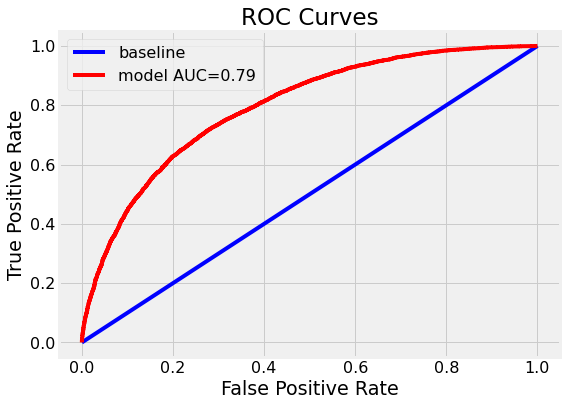

Precision Recall Curve
Precision Recall AUC = 0.575
Confusion matrix:
[[9226 2693]
 [2771 5315]]


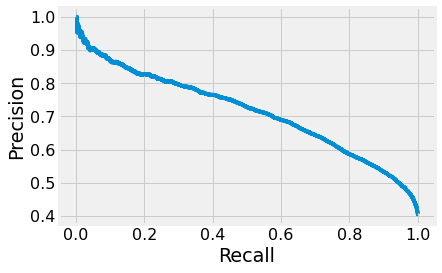

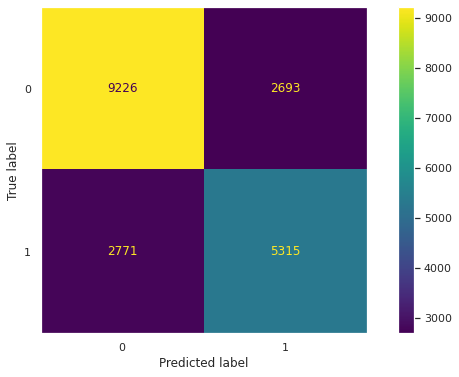

In [47]:
with mlflow.start_run():
    # Hyperparameters:
    ADC_SEED_STATE = 42
    ADC_CRITERION = 'gini'
    ADC_MAX_FEATURES = 'auto'
    ADC_CLASS_WEIGHT = 'balanced'
    ADC_MAX_DEPTH = 12
    
    mlflow.set_tag('sklearn','akwa_ibom_AdaBoost_Augmented')
    mlflow.set_tag('FEG','akwa_ibom_Augmented features')
    
    # Log feature list to MLFlow
    mlflow.log_artifact('./FeatureGroups/akwa_ibom_Augmented_Features.csv')
#     mlflow.log_artifact('model.pkl')
    
    #Log uv to mlflow
    #mlflow.log_artifact('/data/rise_data/unified_view.csv')
    
    # Log parameters to MLflow
    mlflow.log_param("random_state", ADC_SEED_STATE)
    mlflow.log_param("criterion", ADC_CRITERION)
    mlflow.log_param("max_features", ADC_MAX_FEATURES)
    mlflow.log_param("class_weight", ADC_CLASS_WEIGHT)
    mlflow.log_param("max_depth", ADC_MAX_DEPTH)
    
    # Modelling
    DTC = DecisionTreeClassifier(random_state = ADC_SEED_STATE,criterion=ADC_CRITERION, max_features = ADC_MAX_FEATURES, class_weight = ADC_CLASS_WEIGHT,max_depth = ADC_MAX_DEPTH)
    ADC = AdaBoostClassifier(base_estimator=DTC)
    ADC.fit(X_train, y_train)
    model_validation.evaluate_model(ADC, ADC.predict(X_val), ADC.predict_proba(X_val)[:,1], y_train, X_val, y_val, T_labels=None, normalise_conf_mtx=None)
    
    # Metrics
    f1 = round(f1_score(y_val, ADC.predict(X_val)), 3)
    accuracy = round(accuracy_score(y_val, ADC.predict(X_val)), 3)
    precision = round(precision_score(y_val, ADC.predict(X_val)), 3)
    recal = round(recall_score(y_val, ADC.predict(X_val)), 3)
    roc_auc = round(roc_auc_score(y_val, ADC.predict_proba(X_val)[:,1]), 3)
    (tn, fp), (fn, tp) = confusion_matrix(y_val, ADC.predict(X_val))
    specificity = round(tn/(tn+fp), 3)
    mcc = round(matthews_corrcoef(y_val, ADC.predict(X_val)), 3)
    gini = round(model_validation.gini_score(y_val,ADC.predict_proba(X_val)[:,1]),3)
    PR_AUC = round(average_precision_score(y_val, ADC.predict(X_val)), 3)
    brier_loss_score = round(brier_score_loss(y_val, ADC.predict_proba(X_val)[:,1]), 3)

    # Log metrics to MLflow
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recal", recal)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("MCC", mcc)
    mlflow.log_metric("GINI", gini)
    mlflow.log_metric("PR_AUC", PR_AUC)
    mlflow.log_metric("Brier_Loss", brier_loss_score)
    mlflow.log_metric("Specificity", specificity)
    
    # Log model to MLflow
#     mlflow.sklearn.save_model(ADC, "my_model")
    mlflow.sklearn.save_model(ADC,'mlruns/AdaBoost')
    mlflow.sklearn.log_model(ADC, "Augmented: Adaboost Decision tree Base (sklearn)")